In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras import backend as K
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [53]:
datos = pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1278 entries, Unnamed: 0 to Eat
dtypes: float64(1276), int64(2)
memory usage: 158.4 MB


a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $μ=0$ y $σ=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.

In [54]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled   = pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
y_val_scaled = X_val_scaled.pop('Eat').values.reshape(-1,1)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)

b) Para el mismo problema definido anteriormente (sección 1) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (loss) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de gradients (link) en el backend de Keras. Deberá generar un histograma para todos los pesos de cada capa antes y despues del entrenamiento con 250 epochs. Comente.

In [55]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

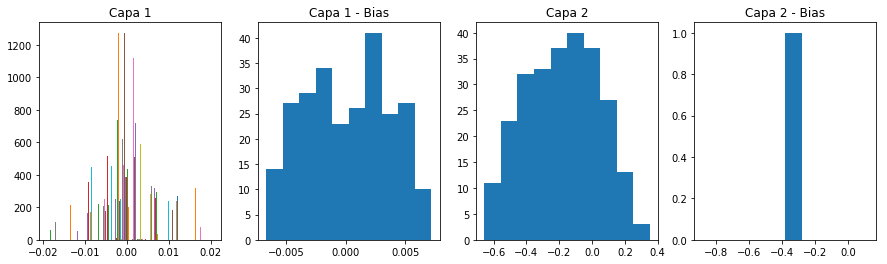

In [12]:
plt.figure(figsize=(15,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 1 - Bias")
plt.hist(evaluated_gradients[1])

plt.subplot(143)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(144)
plt.title("Capa 2 - Bias")
plt.hist(evaluated_gradients[3])

plt.show()

In [56]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [7]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

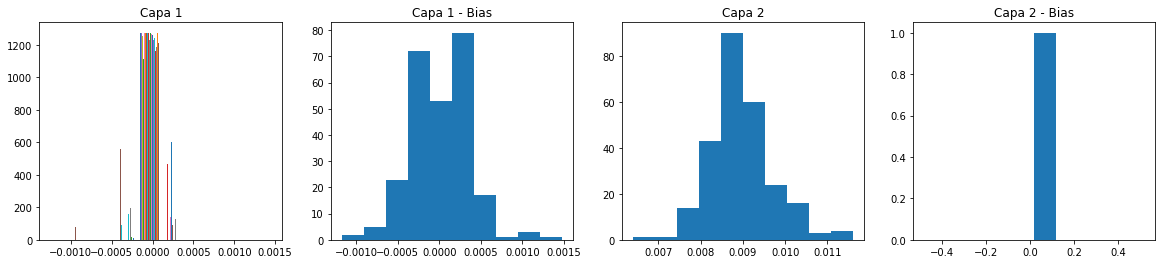

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 1 - Bias")
plt.hist(evaluated_gradients_after[1])

plt.subplot(143)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(144)
plt.title("Capa 2 - Bias")
plt.hist(evaluated_gradients_after[3])

plt.show()

Antes del entrenamiento, los gradientes son obtenidos utilizando los pesos inicializados con una distribución uniforme, por lo que la actualización de ellos serán mayores que los de un modelo que fue entrenado y convergió.
Después del entrenamiento, los gradientes son cercanos a $0$, por lo que la actualización de los pesos es mínima. Esto es un indicio de que el modelo está convergiendo.

c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

In [18]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [19]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

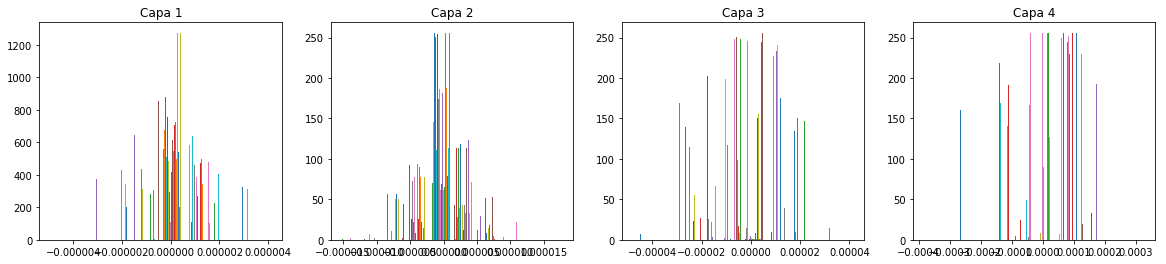

In [20]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients[6])

plt.show()

In [21]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [9]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

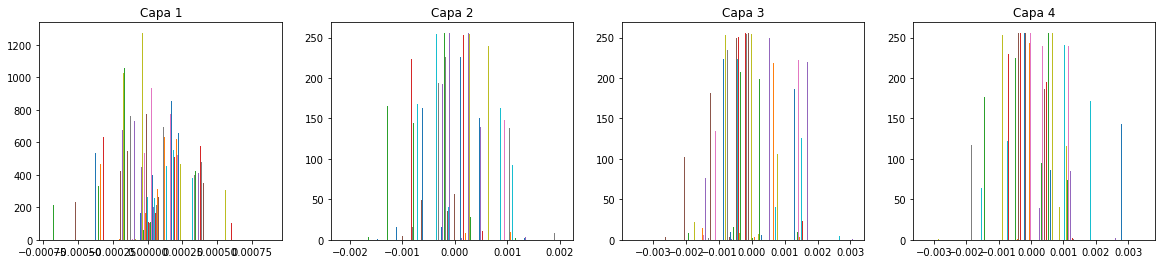

In [10]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients_after[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients_after[6])

plt.show()

Se puede observar el efecto del gradiente desvaneciente, se puede notar en las capas 3 y 4, donde la cuarta se actualiza más que la tercera, mostrando que solo las últimas capas son las que en verdad se actualizan y el resto de capas reciben una actualización más amortiguada.

d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.

In [24]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [25]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

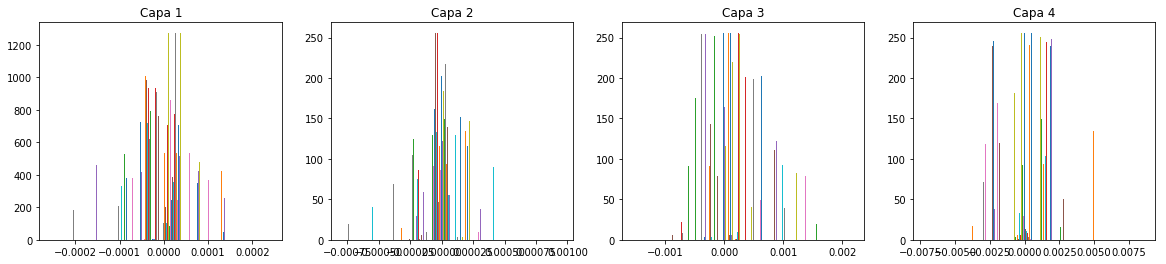

In [26]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients[6])

plt.show()

In [27]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [28]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

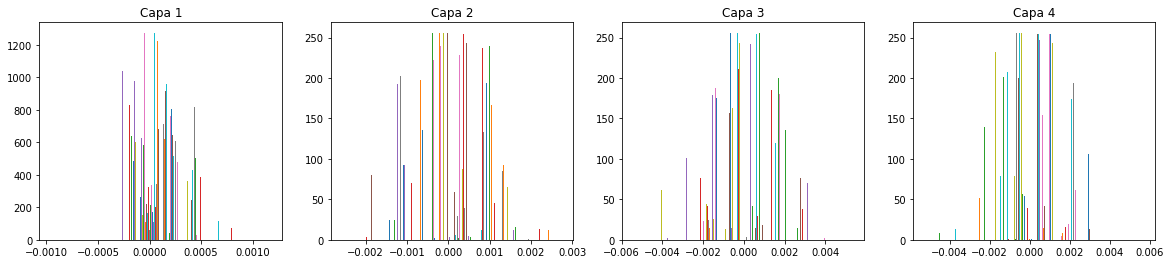

In [29]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients_after[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients_after[6])

plt.show()

Se nota un amortiguamiento en el efecto del gradiente desvaneciente

e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

In [30]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [31]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

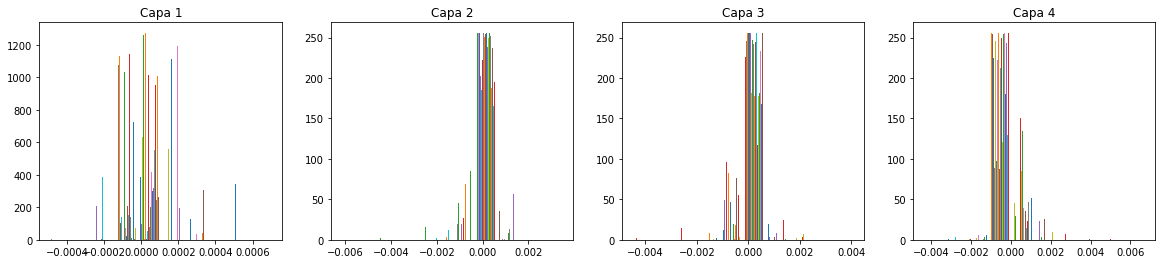

In [32]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients[6])

plt.show()

In [33]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [34]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

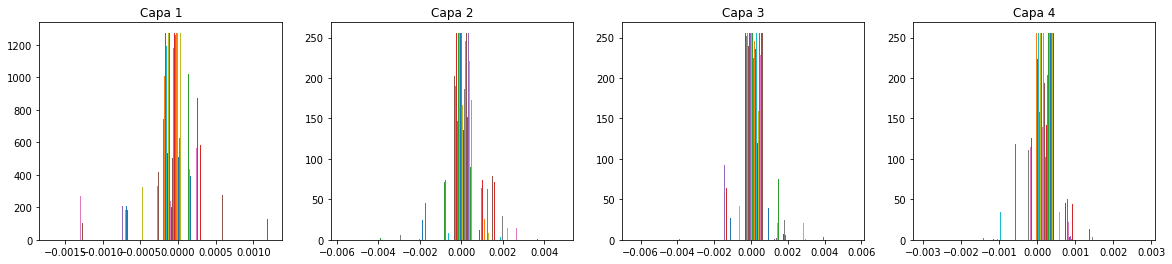

In [35]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients_after[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients_after[6])

plt.show()

Utilizando Inicialización de He

In [36]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [37]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

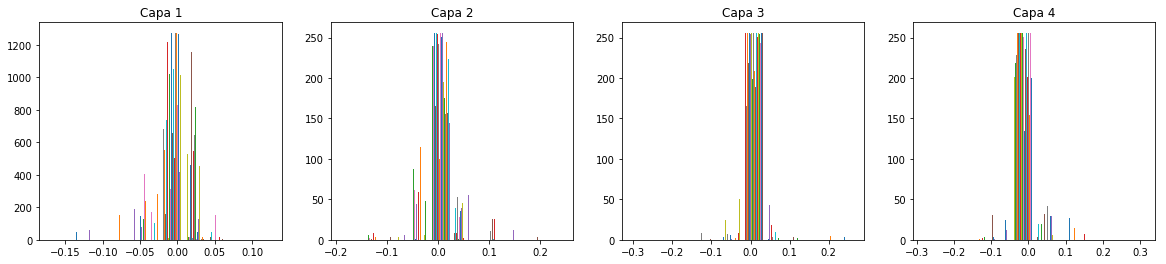

In [38]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients[6])

plt.show()

In [39]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [40]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

/home/fchacon/ann/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6553: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/fchacon/ann/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6554: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: max must be larger than min in range parameter.

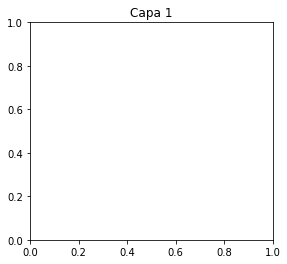

In [41]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients_after[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients_after[6])

plt.show()

La importancia de la inicialización es que con __He__, el modelo no converge. Lo que significa que los valores iniciales afectan en gran medida la búsqueda de un óptimo mínimo.

f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

In [57]:
score = model.evaluate(X_test_scaled, y_test_scaled)
print("Loss Sigmoid: %.3f\n" %(score))

2437/2437 [==============================] - 0s 55us/step
Loss Sigmoid: 0.004



In [58]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [59]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test_scaled, y_test_scaled)
print("Loss Deep NN: %.3f\n" %(score))

g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.

In [42]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')

In [43]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

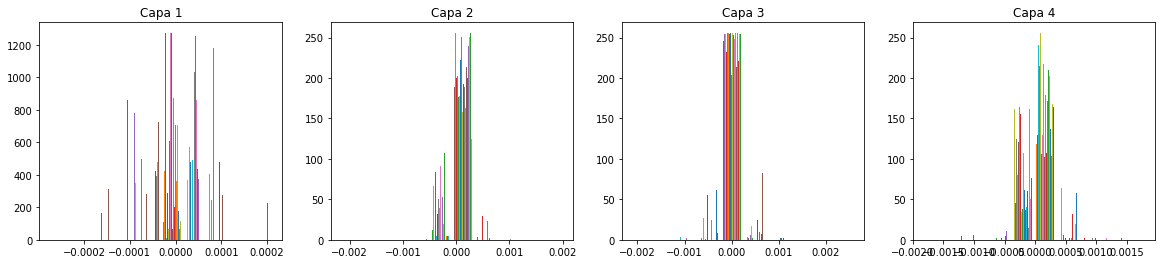

In [44]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients[6])

plt.show()

In [45]:
model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val_scaled))

In [46]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients_after = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_after = [gradient/len(y_train_scaled) for gradient in evaluated_gradients_after]

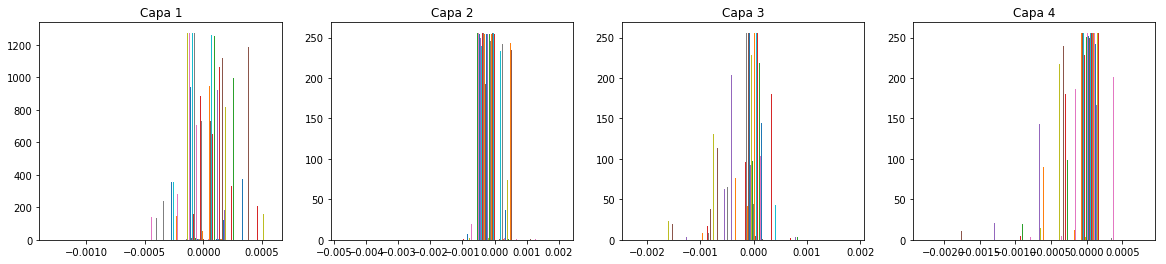

In [47]:
plt.figure(figsize=(20,4))
plt.subplot(141)
plt.title("Capa 1")
plt.hist(evaluated_gradients_after[0])

plt.subplot(142)
plt.title("Capa 2")
plt.hist(evaluated_gradients_after[2])

plt.subplot(143)
plt.title("Capa 3")
plt.hist(evaluated_gradients_after[4])

plt.subplot(144)
plt.title("Capa 4")
plt.hist(evaluated_gradients_after[6])

plt.show()

Al ser de forma similar a la _ReLU_, pero continuamente derivable, la actualización de los pesos es mejor. Los rangos en el eje x de _softplus_ son más acotados que en _ReLU_, ya que los gradientes van convergiendo de mejor forma.

h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?

In [51]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0865 - val_loss: 0.0425
Epoch 2/250
9745/9745 [==============================] - 1s 138us/step - loss: 0.0473 - val_loss: 0.0369
Epoch 3/250
9745/9745 [==============================] - 1s 140us/step - loss: 0.0403 - val_loss: 0.0309
Epoch 4/250
9745/9745 [==============================] - 1s 134us/step - loss: 0.0354 - val_loss: 0.0618
Epoch 5/250
9745/9745 [==============================] - 1s 136us/step - loss: 0.0320 - val_loss: 0.0262
Epoch 6/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0297 - val_loss: 0.0243
Epoch 7/250
9745/9745 [==============================] - 1s 138us/step - loss: 0.0277 - val_loss: 0.0226
Epoch 8/250
9745/9745 [==============================] - 1s 138us/step - loss: 0.0258 - val_loss: 0.0232
Epoch 9/250
9745/9745 [==============================] - 1s 138us/step - loss: 0.0242 - val_loss: 0.0204
Epoch 1

KeyboardInterrupt: 

La red _shallow_ diverge